# Exploratory data analysis

In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.insert(0, module_path)

print(f"Current working directory: {os.getcwd()}")
print(f"Source code is in system path @ {sys.path[0]}")

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working directory: /Users/joshgowdy/GitHub/GB-energy-trading/notebooks
Source code is in system path @ /Users/joshgowdy/GitHub/GB-energy-trading/code


## Load in

In [116]:
def load_auction_data(file_paths:list):
    """
    Load day-ahead auction and balancing mechanism data from a CSV file paths, merge these dataframes, and parse the index as datetime.
    The first row of the merged dataframe is removed, and the data is converted to numeric.

    Seperate the reference price forecasts contianed in the datasets from the actual price and volume data.

    Parameters
    ----------
    file_paths : list
        List of file paths to the CSV files to be loaded.
    Returns
    -------
    auction_data : pd.DataFrame
        Merged dataframe with the auction data.
    reference_forecasts : pd.DataFrame
        Dataframe with the reference forecasts.
    """
    df1=pd.read_csv(file_paths[0], delimiter=';', index_col=0)
    df2=pd.read_csv(file_paths[1], delimiter=';', index_col=0)

    # merge dataframes
    auction_data=df1.merge(df2, left_index=True, right_index=True, how='left')
    # remove first row
    auction_data=auction_data.iloc[1:]
    # convert data to numeric
    auction_data=auction_data.apply(pd.to_numeric, errors='coerce')
    # parse dates
    auction_data.index=auction_data.index.str.replace(r'[\[\]]', '', regex=True)
    auction_data.index=pd.to_datetime(auction_data.index, format='%d/%m/%Y %H:%M')

    # seperate reference price forecasts from actual price and volume data
    reference_forecasts=auction_data.loc[:,auction_data.columns.str.contains('forecast')]

    auction_data=auction_data.loc[:,~auction_data.columns.str.contains('forecast')]

    return auction_data, reference_forecasts

In [117]:
auction_data, reference_forecasts=load_auction_data(['../data/raw/auction_data.csv', '../data/raw/system_prices.csv'])
display(auction_data)

,price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,system_price
Date (WET),,,,,
2021-01-01 00:00:00,68.0,65.73,2923.7,5102.4,73.15
2021-01-01 01:00:00,62.7,64.96,2825.0,4771.5,71.95
2021-01-01 02:00:00,56.0,60.47,2611.4,4176.2,54.56
2021-01-01 03:00:00,50.1,52.50,2669.3,3755.9,70.73
2021-01-01 04:00:00,50.0,48.98,2741.4,4047.5,54.98
...,...,...,...,...,...
2022-09-12 19:00:00,465.6,437.60,5809.2,14484.4,NaN
2022-09-12 20:00:00,418.0,391.45,5480.5,14037.4,NaN
2022-09-12 21:00:00,358.7,342.29,4750.4,12785.3,NaN


## First look and plot

In [82]:
auction_data.describe()

,price_first_auction,price_second_auction,traded_volume_first_auction,traded_volume_second_auction,system_price
count,14881.000000,14881.000000,14881.000000,14879.00000,14837.000000
mean,157.849428,157.359268,3988.068369,9769.17606,152.033555
std,112.796333,114.762815,1071.388704,2768.57308,145.305394
min,-24.900000,-50.000000,991.800000,3329.20000,-90.320000
25%,77.900000,78.040000,3202.800000,7535.40000,73.550000
50%,138.200000,137.140000,3940.700000,9795.60000,123.750000
75%,201.500000,200.040000,4672.200000,11799.45000,203.000000
max,1860.000000,2500.010000,8459.600000,18419.10000,4037.800000


In [83]:
auction_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14881 entries, 2021-01-01 00:00:00 to 2022-09-12 23:00:00
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   price_first_auction           14881 non-null  float64
 1   price_second_auction          14881 non-null  float64
 2   traded_volume_first_auction   14881 non-null  float64
 3   traded_volume_second_auction  14879 non-null  float64
 4   system_price                  14837 non-null  float64
dtypes: float64(5)
memory usage: 697.5 KB


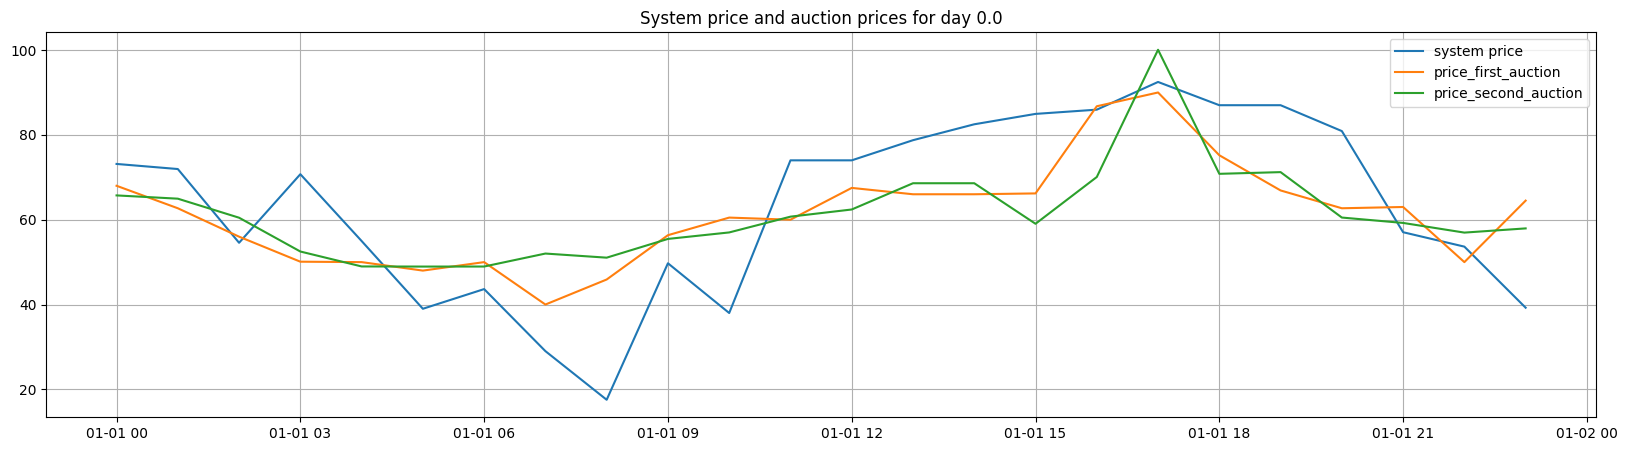

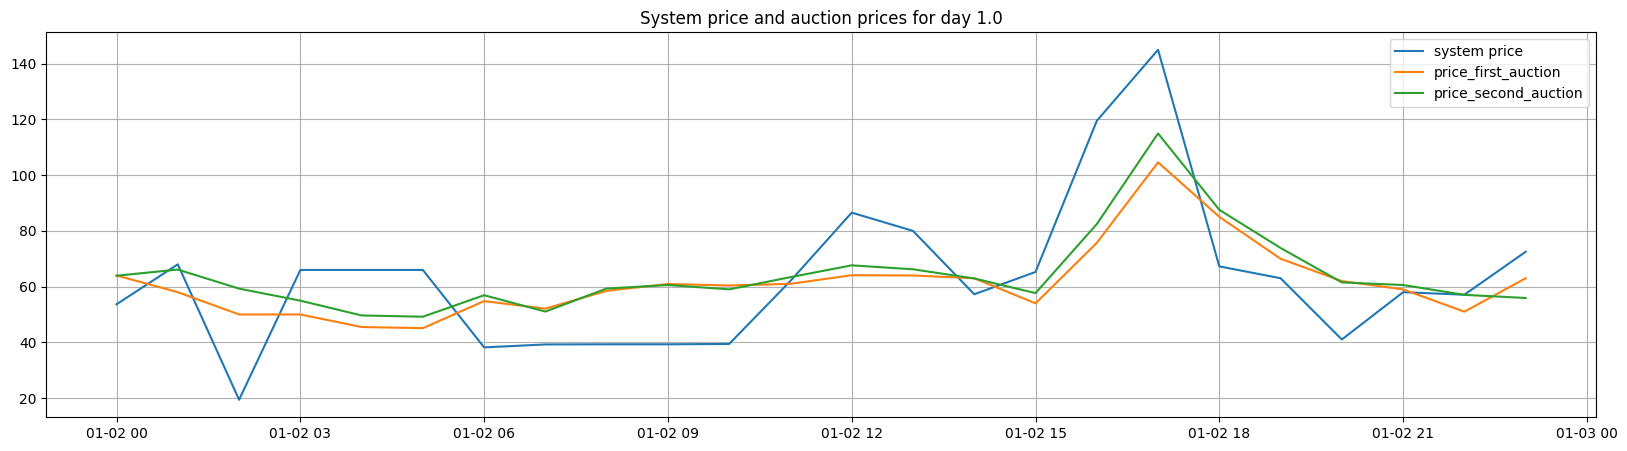

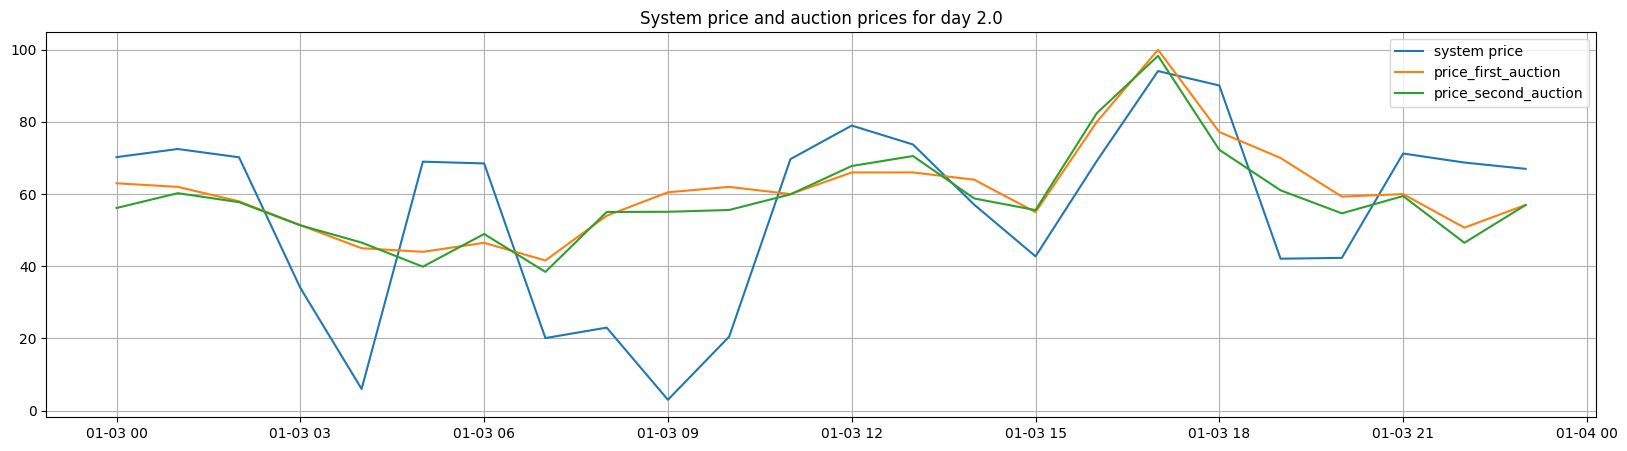

In [84]:
# plot the system price and the auction prices for a few days
days=3
for i in range(0, days*24, 24):
    plt.figure(figsize=(20,5))
    plt.grid()
    plt.plot(auction_data['system_price'].iloc[i:i+24], label='system price')
    plt.plot(auction_data['price_first_auction'].iloc[i:i+24], label='price_first_auction')
    plt.plot(auction_data['price_second_auction'].iloc[i:i+24], label='price_second_auction')
    plt.legend(loc='best')
    plt.title(f'System price and auction prices for day {i/24}')

plot all prices and trade volumes for 2021 2022

Text(0.5, 1.0, 'System price and auction prices')

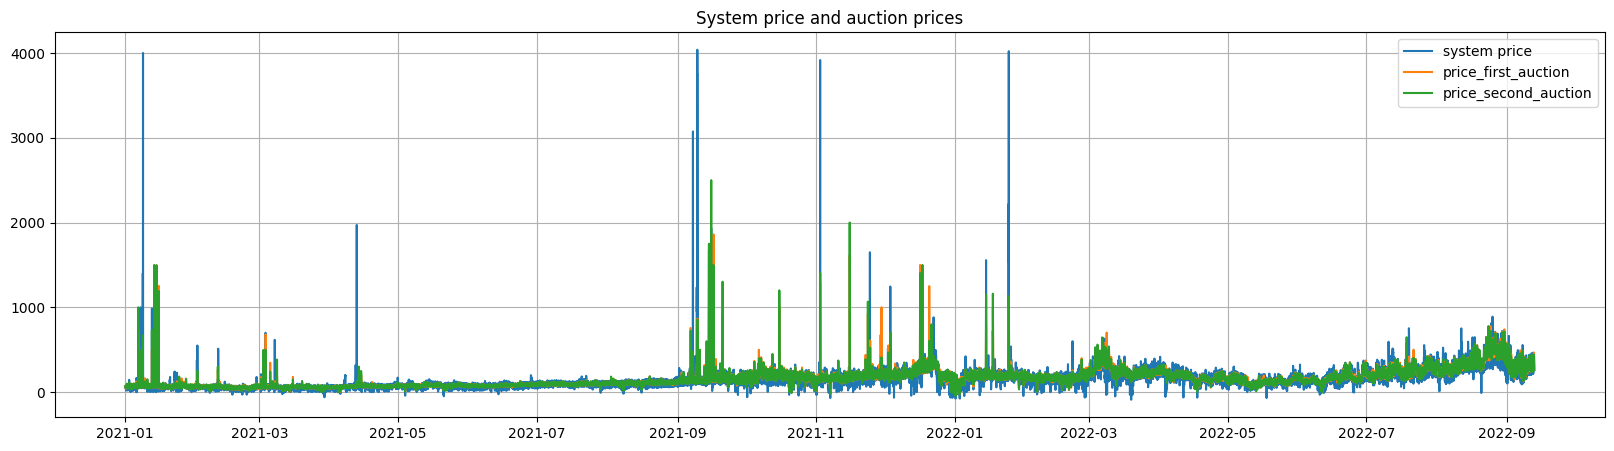

In [85]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(auction_data['system_price'], label='system price')
plt.plot(auction_data['price_first_auction'], label='price_first_auction')
plt.plot(auction_data['price_second_auction'], label='price_second_auction')
plt.legend(loc='best')
plt.title(f'System price and auction prices')

Text(0.5, 1.0, 'Traded volumes')

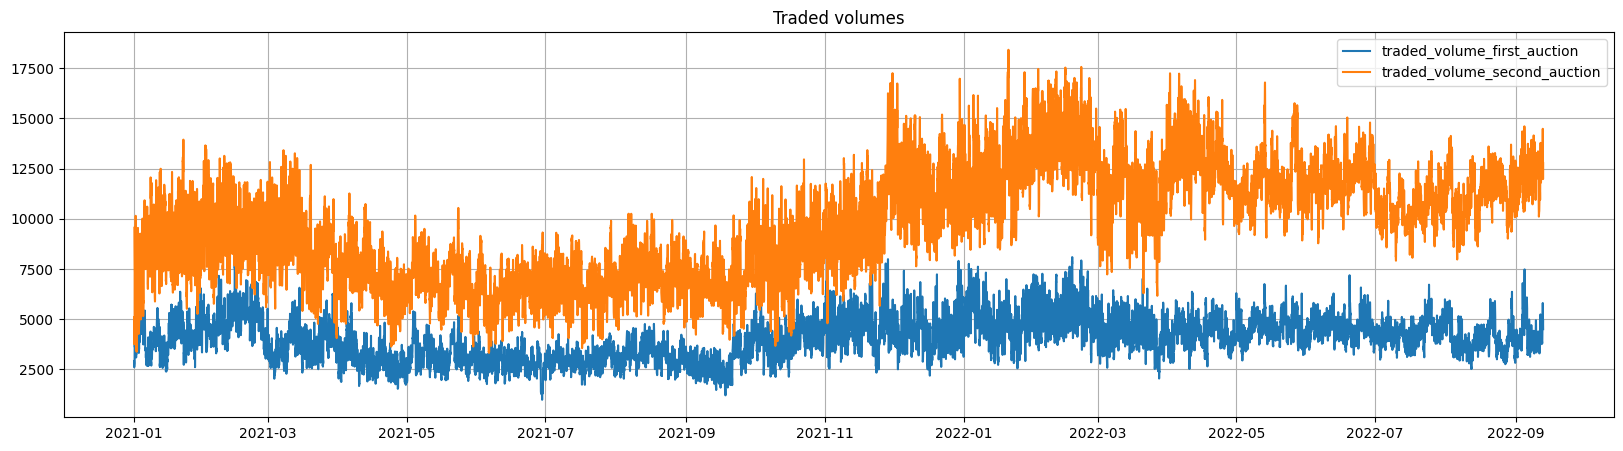

In [86]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(auction_data['traded_volume_first_auction'], label='traded_volume_first_auction')
plt.plot(auction_data['traded_volume_second_auction'], label='traded_volume_second_auction')
plt.legend(loc='best')
plt.title(f'Traded volumes')

Clear 24 hour cycle for auction prices reflecting the daily cycle of solar and demand. Clear correspondence i.e. very strong correlation between two auctions we will be interested in predicting the first auction and then the price difference between auctions.

The second auction has consistently more volume traded. Perhaps as we are close to delivery the volume traded is greater since confidence in generation and demand requirements is higher.

System price exhibits much weaker correlation with the auction prices and a weaker daily cycle. Has much mre volatility. Important to note that the balancing system has much less volume than the day-ahead markets FIND DATA FOR THIS.

## Imputation

find location of null values

In [51]:
def find_loc_null(df):
    """
    Find the location of null values in a dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe to search for null values.

    Returns
    -------
    loc_null : list
        List of tuples with the index and column name of each null value.
    """
    loc_null = []
    for i in range(len(df)):
        for j in range(len(df.columns)):
            if pd.isnull(df.iloc[i,j]):
                loc_null.append((i, df.columns[j]))
    return loc_null

In [87]:
find_loc_null(auction_data)

[(600, 'system_price'),
 (601, 'system_price'),
 (602, 'system_price'),
 (603, 'system_price'),
 (604, 'system_price'),
 (605, 'system_price'),
 (606, 'system_price'),
 (607, 'system_price'),
 (608, 'system_price'),
 (609, 'system_price'),
 (610, 'system_price'),
 (611, 'system_price'),
 (612, 'system_price'),
 (613, 'system_price'),
 (614, 'system_price'),
 (615, 'system_price'),
 (616, 'system_price'),
 (617, 'system_price'),
 (618, 'system_price'),
 (619, 'system_price'),
 (620, 'system_price'),
 (621, 'system_price'),
 (622, 'system_price'),
 (658, 'system_price'),
 (659, 'system_price'),
 (660, 'system_price'),
 (661, 'system_price'),
 (662, 'system_price'),
 (663, 'system_price'),
 (664, 'system_price'),
 (665, 'system_price'),
 (666, 'system_price'),
 (667, 'system_price'),
 (668, 'system_price'),
 (669, 'system_price'),
 (670, 'system_price'),
 (6550, 'traded_volume_second_auction'),
 (6551, 'traded_volume_second_auction'),
 (12382, 'system_price'),
 (14874, 'system_price'),
 (

most null values are consequtive entries that are missing so we must interpolate. The data exhibits a strong 24 hour cycle. We will using the rolling mean taken from the same hour from the past x days and test various values of x. Similarly we will try a more sophisticated method using an STL decomposition.

In [191]:
sample = auction_data.copy()
sample = sample.loc['2021-01-01':'2021-01-10', 'system_price'].to_frame()
sample_missing=sample.copy()
sample_missing.iloc[-50:-30] = np.nan

In [192]:
def impute_with_periodic_rolling_mean(df, column, window_start=2, window_end=2, period=24):
    """
    Impute missing values using a rolling mean that is periodic i.e. considers only every nth value.
    Where n is the period.

    The rolling mean is computed over a window of size `window_start` before the missing value 
    and `window_end` after the missing value.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the column to impute.
    column : str
        The column name to impute.
    window_start : int, optional
        The number of values to consider before the missing value. Default is 2.
    window_end : int, optional
        The number of values to consider after the missing value. Default is 2.
    period : int, optional
        The period to consider for the rolling mean. Default is 24.

    Returns
    -------
    pd.Series
        The column with missing values imputed.
    """
    imputed_df=df.copy()
    imputed_df=imputed_df.reset_index()
    series = imputed_df[column].copy()

    # Iterate over missing values
    for idx in imputed_df[imputed_df[column].isna()].index:
        # Select every nth value around the missing index
        start = max(0, idx - window_start * period)
        end = min(idx + window_end * period + 1, len(series)-1)
        values =series.iloc[start:end:period].dropna()

        # Compute the mean and impute the value
        if not values.empty:
            imputed_df.loc[idx, column] = values.mean()
        
    imputed_df=imputed_df.set_index('Date (WET)')
    return imputed_df

system_price    0
dtype: int64


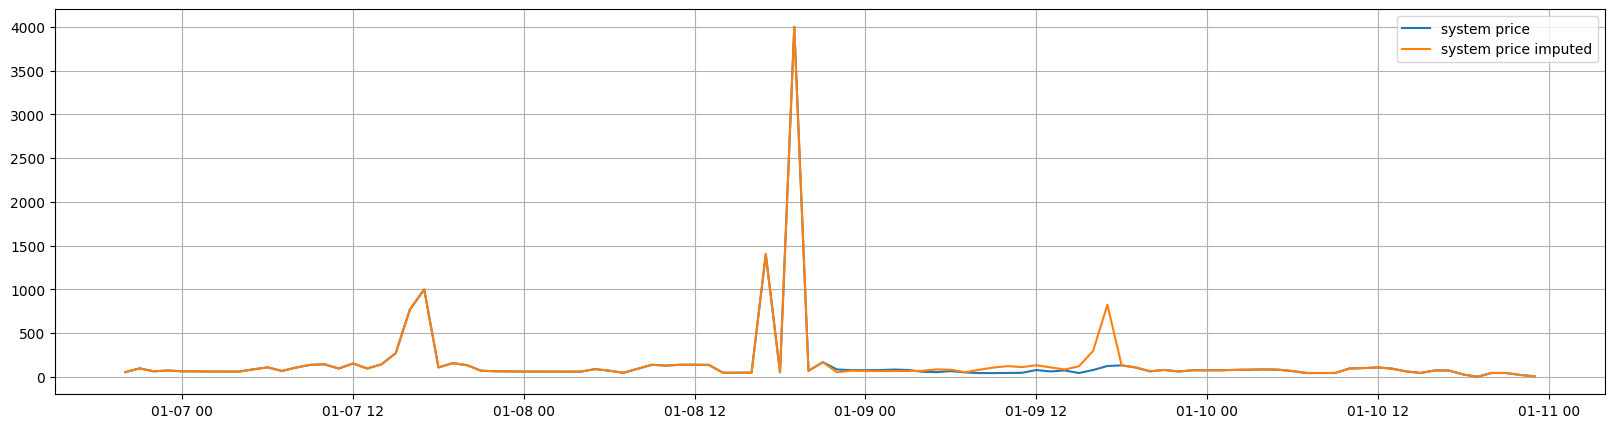

In [193]:
sample_imputed = impute_with_periodic_rolling_mean(sample_missing, 'system_price', window_start=2, window_end=2, period=24)
print(sample_imputed.isnull().sum())
# check if the imputed values are reasonable
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(sample.iloc[-100:], label='system price')
plt.plot(sample_imputed.iloc[-100:], label='system price imputed')
plt.legend(loc='best')

In [194]:
def STL_decompose_data(df, column, period:int):
    """
    Decompose a time series using STL decomposition. 
    Results are stored in a dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with the time series to decompose.
    column : str
        Column name of the time series to decompose.
    period : int
        Period of the time series.

    Returns
    -------
    result : STL
        STL decomposition result.
    """
    # Interpolate missing values first in order to decompose, these interpolated values will
    # only slightly influence the seasonal and trand components
    stl = STL(df[column].interpolate(), period=period)
    result = stl.fit()
    return result

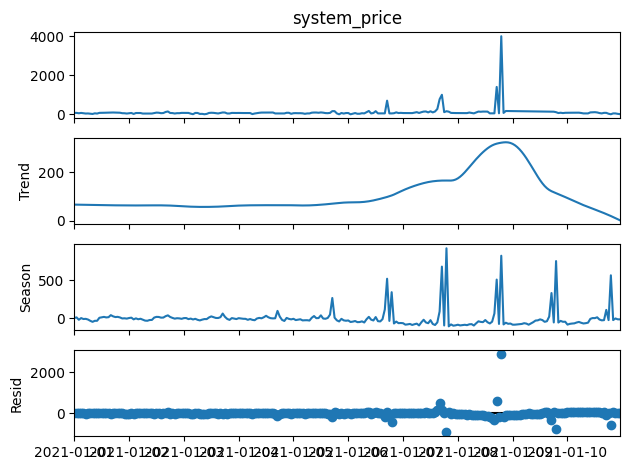

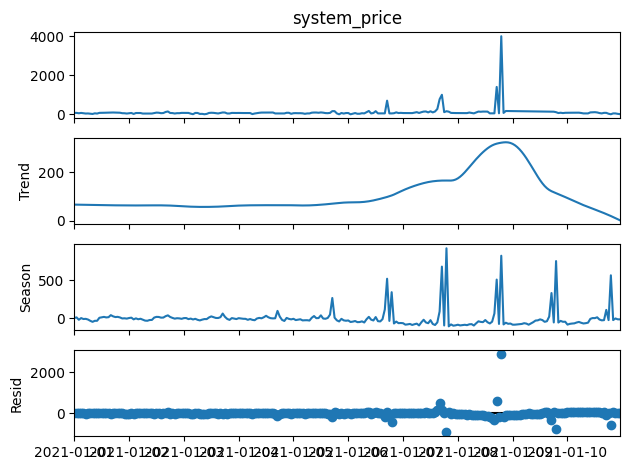

In [195]:
results=STL_decompose_data(sample_missing, 'system_price', 24)
results.plot()

In [198]:
def impute_with_STL_decomposition(df, column, period:int, iterations:int=1):
    """
    Impute values in a dataframe using STL decomposition.

    Values are imputed according to the seasonal and trend components of the STL decomposition.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe to impute.
    locs : tuple
        Tuple of tuples with the index and column name of each value to be imputed.
    period : int
        Period of the seasonal component.
    Returns
    -------
    df_imputed : pd.DataFrame
        Dataframe with missing values imputed.
    """
    imputed_df=df.copy()
    
    missing_indices=imputed_df[imputed_df[column].isna()].index

    for _ in range(iterations):
        res=STL_decompose_data(imputed_df, column, period)

        impute_values = res.seasonal + res.trend

        imputed_df.loc[missing_indices, column] = impute_values.loc[missing_indices]
    
    return imputed_df

system_price    0
dtype: int64


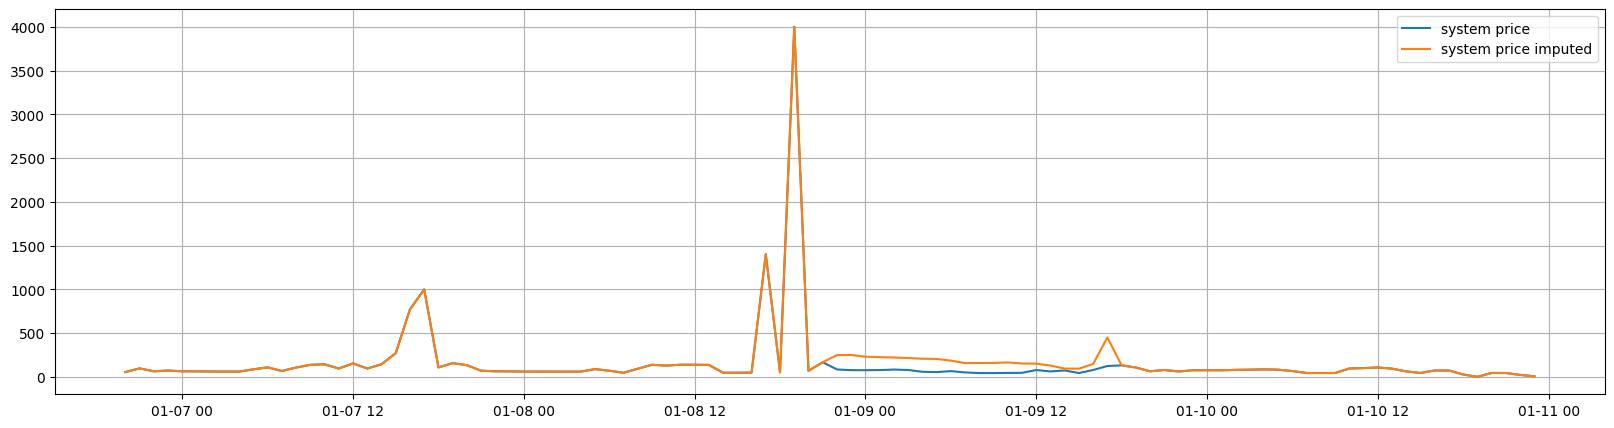

In [199]:
sample_imputed = impute_with_STL_decomposition(sample_missing, 'system_price', period=24)
print(sample_imputed.isnull().sum())
# check if the imputed values are reasonable
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(sample.iloc[-100:], label='system price')
plt.plot(sample_imputed.iloc[-100:], label='system price imputed')
plt.legend(loc='best')


In [ ]:
def impute_missing_values(df, method='periodic rolling mean', method_params=[24, 1, 1]):

    if method == 'periodic rolling mean':
        if len(method_params) != 3:
            raise ValueError("method_params must be a list of 3 integers: [period, window_start, window_end]")
        missing_locs=find_loc_null(auction_data)
        df=impute_with_periodic_rolling_mean(df, missing_locs, method_params[0], method_params[1], method_params[2])
        return df
    elif method == 'STL':
        
    else:
        raise ValueError("Method must be one of 'periodic rolling mean'")
